Student Name: Sajin Mohamed Pallikkathodi Erathali

Student ID: 23037601

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?
                         # used to place the model in training mode

    for batch, (X, y) in enumerate(dataloader):
        # print(type(X))
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it
                                            # Moving the input data to the GPU/CPU device we are using for efficient computation
        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
                                            # predicting the results for the input provided
        loss = loss_fn(pred, y)             #<--- what is this for?
                                            # difference between outputs and true labels are calculated as loss. How far off is the predicted result from the expected results

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
                                            # does the backward pass calculate the gradients that will direct the learning. Using the gradients it changes the weightes nad baises to reduce the loss
        optimizer.step()                    #<--- what is this for?
                                            # based on the optimizer(driving the learning) defined, one learning step is performed, here the gradients from the backward call made above are used to move the learning weights to reduce the loss
        optimizer.zero_grad()               #<--- what is this for?
                                            # gradients accumulated over each batch is reset else the gradients would keep accuumulating and provide incorrect values and learning would be incorrect

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26421880/26421880 [00:02<00:00, 10733530.72it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173845.78it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3187483.28it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18129535.68it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



T-shirt/top Pullover Shirt Sneaker


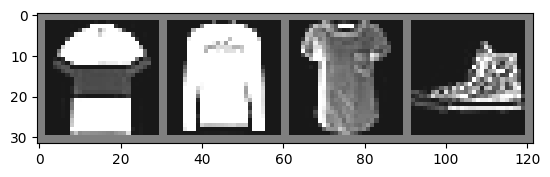

In [4]:
##############################
# Your code below

import numpy as np

# defining a transform to normalize and resize the data
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.2859,), (0.3530))])

# downloading the data(train and test)
train_dataset = datasets.FashionMNIST('./data', train = True, download = True, transform = transform)
# note the use of train = False to denote the download of test data
test_dataset = datasets.FashionMNIST('./data', train = False, download = True, transform = transform)

# print("train data set is ", train_dataset ,"end")
batch_size = 64
# defining a dataloader for train and test with batch size of 64 as required
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)

# forming a map for prining later
class_labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
                5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


# below obtained from the material provided
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy ()
  plt.imshow (np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

import torchvision
# show 4 images with its labels
imshow (torchvision.utils.make_grid(images[:4]))
print(' '. join('%5s' % class_labels[labels[j].item()] for j in range(4)))



---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
##############################
# Your code below

'''Define model called Neural network that takes in 784 input parameters
   and uses 3 hidden layers of size 100, 100 and 50 and applies ReLU after each
   fully connected layer and produces an output layer of 10'''
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 100) # 100, 100, 50 relu after each linear
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        out = self.flatten(x)
        # print(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

# moving it to the device(GPU) selected above
model = NeuralNetwork().to(device)
summary(model, (1,28*28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [5]:
def Train_model(train_loader, test_loader, model):
  # Define the loss function and the Adam optimizer with a learning rate of 0.001
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  # Note, replace model with the instance name of your model

  ##############################
  # Your code below
  epochs = 20
  train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimizer, epochs)
  return train_loss, train_accuracy, test_loss, test_accuracy

In [ ]:
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_loader, test_loader, model)

Epoch 1:

loss: 2.284388  [   64/60000]
loss: 0.595560  [ 6464/60000]
loss: 0.467041  [12864/60000]
loss: 0.431289  [19264/60000]
loss: 0.406511  [25664/60000]
loss: 0.306850  [32064/60000]
loss: 0.544876  [38464/60000]
loss: 0.521935  [44864/60000]
loss: 0.390816  [51264/60000]
loss: 0.229429  [57664/60000]
Train Error: 
 Accuracy: 84.1%, Avg loss: 0.421538 

Test Error: 
 Accuracy: 83.1%, Avg loss: 0.464013 

Epoch 2:

loss: 0.305858  [   64/60000]
loss: 0.511443  [ 6464/60000]
loss: 0.393022  [12864/60000]
loss: 0.459787  [19264/60000]
loss: 0.270652  [25664/60000]
loss: 0.339316  [32064/60000]
loss: 0.215400  [38464/60000]
loss: 0.452787  [44864/60000]
loss: 0.395685  [51264/60000]
loss: 0.354080  [57664/60000]
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.321919 

Test Error: 
 Accuracy: 86.4%, Avg loss: 0.374852 

Epoch 3:

loss: 0.412515  [   64/60000]
loss: 0.395478  [ 6464/60000]
loss: 0.349502  [12864/60000]
loss: 0.336994  [19264/60000]
loss: 0.440962  [25664/60000]
loss: 0.26

In [15]:
# defining function for later use
def plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy) :
  train_loss_percent = [loss * 100 for loss in train_loss]
  test_loss_percent = [loss * 100 for loss in test_loss]
  train_accuracy_percent = [acc * 100 for acc in train_accuracy]
  test_accuracy_percent = [acc * 100 for acc in test_accuracy]

  # Plotting the training and testing loss
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.title("Training and Testing Loss over Epochs")
  plt.plot(range(1,len(train_loss) + 1), train_loss_percent, label="Train")
  plt.plot(range(1,len(test_loss) + 1), test_loss_percent, label="Test")
  plt.xlabel("Epochs")
  plt.ylabel("Loss(%)")
  plt.xticks(range(1, len(train_loss) + 1, 2))
  plt.legend()

  # Plotting the training and testing accuracy
  plt.subplot(1,2,2)
  plt.title("Training and Testing Accuracy over Epochs")
  plt.plot(range(1,len(train_accuracy) + 1), train_accuracy_percent, label="Train")
  plt.plot(range(1,len(test_accuracy) + 1), test_accuracy_percent, label="Test")
  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy(%)")
  plt.legend()
  plt.xticks(range(1, len(train_accuracy) + 1, 2))
  plt.tight_layout()
  plt.show()

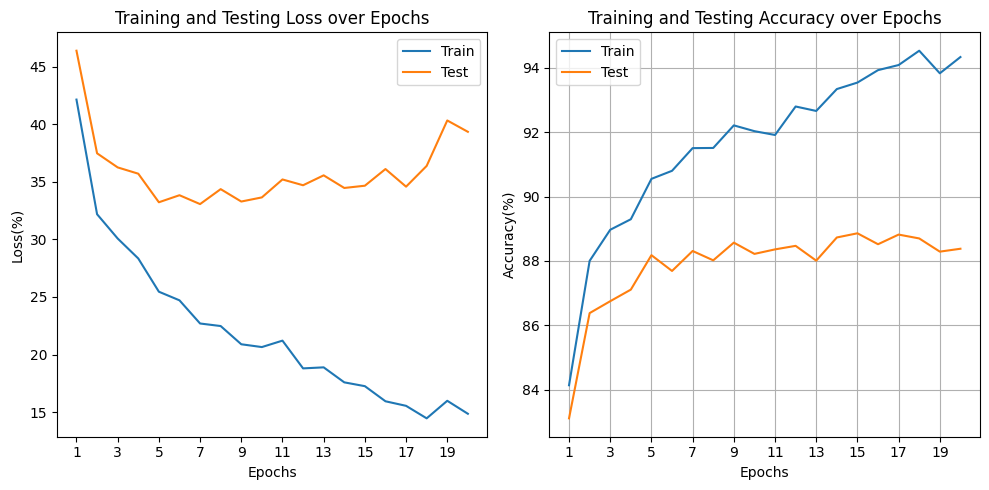

In [ ]:
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

<span style="color:green"> The graphs show training and test loss over the 20 epochs and the accuracy of test and train. Both the training and test loss decrease for initial few epochs, and then we see a divergence in behaviour of the loss between the test and train. While the train loss does decrease with a slope the test loss seems to fall initially but then start to rise. This implies there is the model is overfitting the data using the train data.

On the right we see the train and test accuracy plotted. The graph shows a steady rise in accuracy for the initial few epochs, then the train accuracy does increase, however, the rise in test accuracy declines after 5 epochs. The maximum test accuracy I can observe with the model described above is 88.9% and the train accuracy is 94.5%. This wide gap in the test and train accuracy shows overfitting.</span>  


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

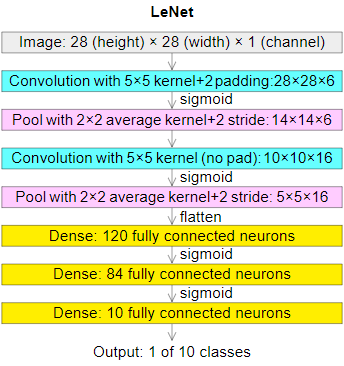

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
##############################
# Your code below

import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class LeNet5 (nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # define first convolution with 6 output and 5 * 5 filters(kernels) and padding = 2
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
    # define sigmoid function
    self.sigmoid = nn.Sigmoid()
    # define flatten
    self.flatten = nn.Flatten()
    # using average pooling
    self.pool = nn.AvgPool2d(2, 2)
    # define 2nd convolution with 6 inputs(output from the previous layer) and 5 * 5 kernels
    self.conv2 = nn.Conv2d(6, 16, 5)
    # defining fully connected layer 1
    self.fc1 = nn.Linear(5*5*16, 120)
    # defining fully connected layer 2 taking 120 input(output from the previous) and forming 84 outputs
    self.fc2 = nn.Linear(120, 84)
    # defining fully connected layer 2 taking 84 input(output from the previous) and forming 10 outputs
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # convolve with 5 x 5 kernel and padding 2
    x = self.conv1(x)
    # apply sigmoid activation function as described in the question
    x = self.sigmoid(x)
    # using average pooling as is used in LeNet5
    x = self.pool(x)

    # 2nd convolution with 5 x 5 kernel
    x = self.conv2(x)
    # apply sigmoid activation function as described in the question
    x = self.sigmoid(x)
    # using average pooling as is used in LeNet5
    x = self.pool(x)

    # flatten before moving it to fully connected layers since they expect a 1D input
    x = self.flatten(x)
    x = self.fc1(x)
    # applying sigmoid activation between fully connected layers
    x = self.sigmoid(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    x = self.fc3(x)
    return x

model = LeNet5().to(device)
summary(model, (1,28,28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [ ]:
# calling the train loop
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_loader, test_loader, model)

Epoch 1:

loss: 2.379992  [   64/60000]
loss: 1.851085  [ 6464/60000]
loss: 1.235602  [12864/60000]
loss: 0.990789  [19264/60000]
loss: 0.959769  [25664/60000]
loss: 0.950894  [32064/60000]
loss: 0.802555  [38464/60000]
loss: 0.536476  [44864/60000]
loss: 0.609443  [51264/60000]
loss: 0.626273  [57664/60000]
Train Error: 
 Accuracy: 75.2%, Avg loss: 0.665704 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.685291 

Epoch 2:

loss: 0.625382  [   64/60000]
loss: 0.811724  [ 6464/60000]
loss: 0.638781  [12864/60000]
loss: 0.609995  [19264/60000]
loss: 0.671372  [25664/60000]
loss: 0.658901  [32064/60000]
loss: 0.521809  [38464/60000]
loss: 0.713878  [44864/60000]
loss: 0.499793  [51264/60000]
loss: 0.521507  [57664/60000]
Train Error: 
 Accuracy: 78.8%, Avg loss: 0.556584 

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.578455 

Epoch 3:

loss: 0.411249  [   64/60000]
loss: 0.442355  [ 6464/60000]
loss: 0.533544  [12864/60000]
loss: 0.601855  [19264/60000]
loss: 0.451710  [25664/60000]
loss: 0.68

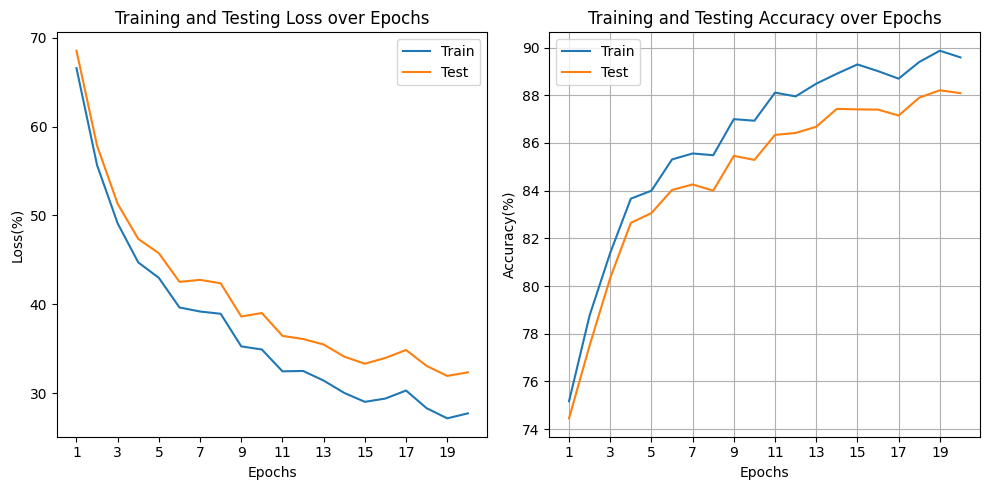

In [ ]:
# plotting the graph showing the Train and Test loss and accuracy
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

<span style="color:green"> Here we find the graph of training and testing loss behaving similarly as the both are continuing their descent as the epochs progress. And due to this we get a better model without overfitting. However the accuracy doesnt seem to improve from the previous graphs. As shown on the plot of Train and Test accuracy, both continue their rise as the epochs progress and we can see the max test accuracy at 88.8% and the max train accuracy at 90.2%.

This is due to the fact that the number of parameters(61706) trained here is much less than the previous case(94160). Also we have used Sigmoid as the activation function here and in the previous I had used a ReLU, which seems to be working really well for this problem(see below). This indicates the importance of using a better activation function. While in the previous example I used a better activation function I did not do any convolution or pooling, here I did do a couple of convolution and an average pooling after each convolution. This could also have led to the difference in the rate of overfitting as it is considerably less compared to the previous graph. </span>  

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>  

<font color='green'>An alternate way to implement LeNet5 using nn.Sequential and ReLU and Max Pooling which improves the accuracy</font>


In [ ]:
##############################
# Your code below

import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class LeNet5_Morderized(nn.Module):
  def __init__(self):
    super(LeNet5_Morderized, self).__init__()
    self.flatten = nn.Flatten()
    '''implementing max pooling and using ReLU activation function
       resulted in greater test and train accuracy(based on trials).'''
    # applying the convolution and ReLU and MaxPooling in sequence for conv1 and conv2
    self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
    self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # applying the conv1
    x = self.conv1(x)
    # applying conv2 on the result of conv1
    x = self.conv2(x)
    # flatten the output of conv2 to (batch_size, 5*5*16)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

model = LeNet5_Morderized().to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Tot

In [ ]:
# calling the train loop
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_loader, test_loader, model)

Epoch 1:

loss: 2.295954  [   64/60000]
loss: 0.596198  [ 6464/60000]
loss: 0.677904  [12864/60000]
loss: 0.394692  [19264/60000]
loss: 0.690481  [25664/60000]
loss: 0.320751  [32064/60000]
loss: 0.457055  [38464/60000]
loss: 0.380589  [44864/60000]
loss: 0.476552  [51264/60000]
loss: 0.285838  [57664/60000]
Train Error: 
 Accuracy: 85.2%, Avg loss: 0.402773 

Test Error: 
 Accuracy: 84.4%, Avg loss: 0.435256 

Epoch 2:

loss: 0.553656  [   64/60000]
loss: 0.245080  [ 6464/60000]
loss: 0.533624  [12864/60000]
loss: 0.575278  [19264/60000]
loss: 0.245438  [25664/60000]
loss: 0.208109  [32064/60000]
loss: 0.359926  [38464/60000]
loss: 0.190952  [44864/60000]
loss: 0.353078  [51264/60000]
loss: 0.103919  [57664/60000]
Train Error: 
 Accuracy: 88.6%, Avg loss: 0.312921 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.349149 

Epoch 3:

loss: 0.346930  [   64/60000]
loss: 0.243224  [ 6464/60000]
loss: 0.282605  [12864/60000]
loss: 0.509799  [19264/60000]
loss: 0.226199  [25664/60000]
loss: 0.37

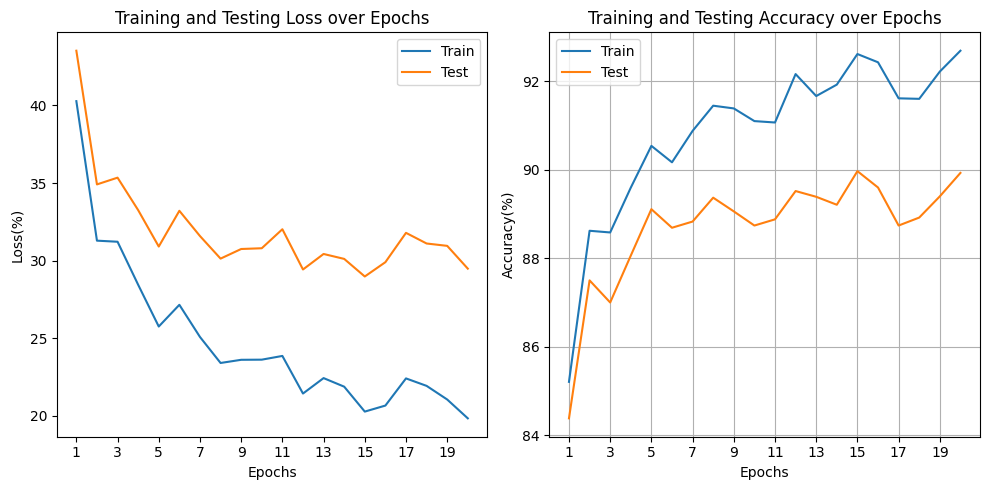

In [ ]:
# plotting the train and test loss and accuracy
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

<span style="color:green"> The mordernized LeNet 5 is an adaptation of the LeNet 5 model described above with the change in activation function to ReLU from the Sigmoid and the pooling from the Average pooling to MaxPooling. The training and test loss has had a considerable decrease in the first couple of epochs itself, compared to the previous where it took almost half the epoch size specified to reach the loss we obtained here. The initial test and train loss was also less here. Here we see number of parameters used for training are identical to the previous one(61706), however, we see there exist considerable overfitting compared to the above. The best test accuracy received here is 90% and train accuracy is 92.6%. Here as we can see the overfitting has increased compared to the previous, however, we see an increase in the test accuracy.</span>

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
##############################
# Your code below

import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 5, padding=2)

    self.pool = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(16, 32, 5, padding = 2)

    self.fc1 = nn.Linear(32*7*7, 10)



  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 32*7*7)
    x = self.fc1(x)
    return x

model = CNN().to(device)
summary(model, (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]          12,832
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.11
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [ ]:
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_loader, test_loader, model)

Epoch 1:

loss: 2.318772  [   64/60000]
loss: 0.507422  [ 6464/60000]
loss: 0.494984  [12864/60000]
loss: 0.363311  [19264/60000]
loss: 0.402517  [25664/60000]
loss: 0.289994  [32064/60000]
loss: 0.401751  [38464/60000]
loss: 0.439598  [44864/60000]
loss: 0.478492  [51264/60000]
loss: 0.339236  [57664/60000]
Train Error: 
 Accuracy: 88.8%, Avg loss: 0.313825 

Test Error: 
 Accuracy: 87.4%, Avg loss: 0.344453 

Epoch 2:

loss: 0.254735  [   64/60000]
loss: 0.166123  [ 6464/60000]
loss: 0.208141  [12864/60000]
loss: 0.213461  [19264/60000]
loss: 0.353458  [25664/60000]
loss: 0.227532  [32064/60000]
loss: 0.279786  [38464/60000]
loss: 0.216303  [44864/60000]
loss: 0.210648  [51264/60000]
loss: 0.154123  [57664/60000]
Train Error: 
 Accuracy: 90.8%, Avg loss: 0.256498 

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.298417 

Epoch 3:

loss: 0.125618  [   64/60000]
loss: 0.220829  [ 6464/60000]
loss: 0.221441  [12864/60000]
loss: 0.268027  [19264/60000]
loss: 0.281232  [25664/60000]
loss: 0.31

<span style="color:green"> With 28938 training parameters I was able to raise the test accuracy to 91.7%. However the train accuracy also climbed to 97.2% which is a clear indicator of overfitting. I used a 5x5 kernel and MaxPooling and ReLU for this.</span>

#An improved CNN


In [30]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        # Add a third convolutional layer that takes in 32 parameters and produces 64 output without padding and using the same the 3x3 kernel
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
       BatchNorm2d-2           [-1, 16, 30, 30]              32
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 32, 17, 17]           4,640
       BatchNorm2d-5           [-1, 32, 17, 17]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 6, 6]          18,496
       BatchNorm2d-8             [-1, 64, 6, 6]             128
         MaxPool2d-9             [-1, 64, 3, 3]               0
           Linear-10                  [-1, 120]          69,240
           Linear-11                   [-1, 10]           1,210
Total params: 93,970
Trainable params: 93,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [31]:
# calling the train loop
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_loader, test_loader, model)

Epoch 1:

loss: 2.301211  [   64/60000]
loss: 0.465317  [ 6464/60000]
loss: 0.452121  [12864/60000]
loss: 0.554264  [19264/60000]
loss: 0.342431  [25664/60000]
loss: 0.283026  [32064/60000]
loss: 0.365415  [38464/60000]
loss: 0.297937  [44864/60000]
loss: 0.420311  [51264/60000]
loss: 0.438433  [57664/60000]
Train Error: 
 Accuracy: 90.1%, Avg loss: 0.273699 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.308041 

Epoch 2:

loss: 0.100580  [   64/60000]
loss: 0.196121  [ 6464/60000]
loss: 0.360688  [12864/60000]
loss: 0.401820  [19264/60000]
loss: 0.155938  [25664/60000]
loss: 0.269517  [32064/60000]
loss: 0.231656  [38464/60000]
loss: 0.102481  [44864/60000]
loss: 0.192268  [51264/60000]
loss: 0.134395  [57664/60000]
Train Error: 
 Accuracy: 91.7%, Avg loss: 0.227131 

Test Error: 
 Accuracy: 89.7%, Avg loss: 0.286539 

Epoch 3:

loss: 0.226147  [   64/60000]
loss: 0.261389  [ 6464/60000]
loss: 0.191701  [12864/60000]
loss: 0.429631  [19264/60000]
loss: 0.172855  [25664/60000]
loss: 0.31

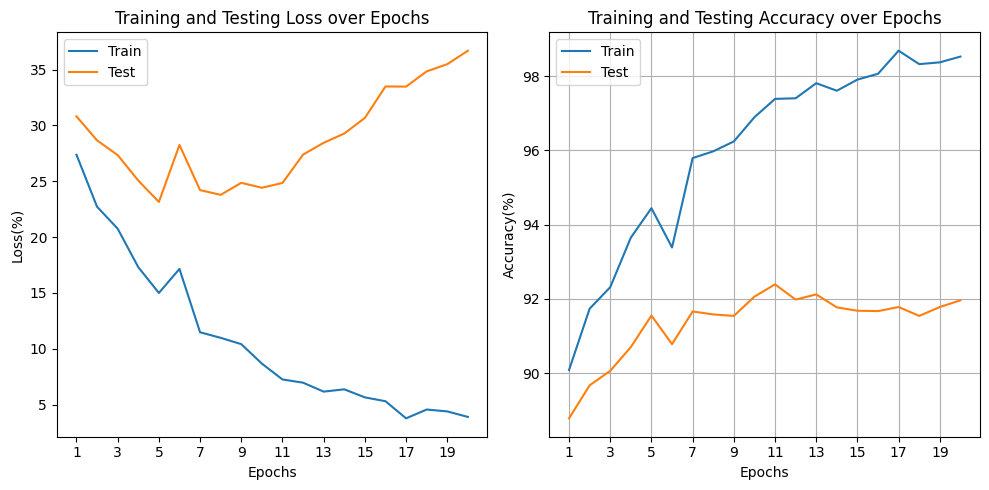

In [32]:
# plotting the train and test loss and accuracy
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

<span style="color:green"> Here I have adapted the LeNet5 classifier model and added another layer with 3x3 kernel with no padding and applied batchnorm after each layer. This increased the number of parameters to 93970. I also used the ReLU after the batch normalization. I also added another fully connected layer at the end. This gives me a maximum test accuracy as 92.4% and train accuracy as 97.4%.</span>

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [ ]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

# Approach 1 : Using random weights(weights=None)

In [ ]:
##############################
# Your code below
resnet18_random = torchvision.models.resnet18(weights=None)
resnet18_random.fc = nn.Linear(resnet18_random.fc.in_features, 10)  # Replace the fully connected layer
model = resnet18_random.to(device)
params = resnet18_random.state_dict()
summary(model, (3,7,7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           9,408
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

In [ ]:
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_dataloader, test_dataloader, model)

Epoch 1:

loss: 2.569363  [   64/60000]
loss: 0.469928  [ 6464/60000]
loss: 0.350273  [12864/60000]
loss: 0.495145  [19264/60000]
loss: 0.551975  [25664/60000]
loss: 0.429372  [32064/60000]
loss: 0.291007  [38464/60000]
loss: 0.477166  [44864/60000]
loss: 0.297339  [51264/60000]
loss: 0.449782  [57664/60000]
Train Error: 
 Accuracy: 85.0%, Avg loss: 0.389709 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.430191 

Epoch 2:

loss: 0.274123  [   64/60000]
loss: 0.298254  [ 6464/60000]
loss: 0.259653  [12864/60000]
loss: 0.302924  [19264/60000]
loss: 0.290978  [25664/60000]
loss: 0.368102  [32064/60000]
loss: 0.222048  [38464/60000]
loss: 0.370145  [44864/60000]
loss: 0.269540  [51264/60000]
loss: 0.288602  [57664/60000]
Train Error: 
 Accuracy: 85.9%, Avg loss: 0.362848 

Test Error: 
 Accuracy: 83.7%, Avg loss: 0.415537 

Epoch 3:

loss: 0.222771  [   64/60000]
loss: 0.270327  [ 6464/60000]
loss: 0.223037  [12864/60000]
loss: 0.304202  [19264/60000]
loss: 0.283217  [25664/60000]
loss: 0.37

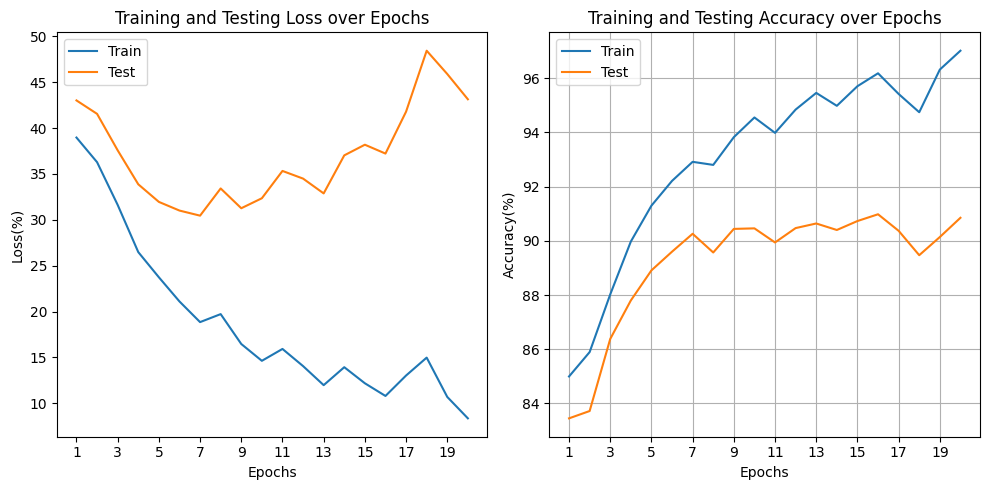

In [ ]:
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

# Approach 2 : Default or IMAGENET1K_V1 weights

In [ ]:
##############################
# Your code below
resnet18_default = torchvision.models.resnet18(weights='DEFAULT') # equivalent to weights='IMAGENET1K_V1'
resnet18_default.fc = nn.Linear(resnet18_default.fc.in_features, 10)  # Replace the fully connected layer
model = resnet18_default.to(device)
params = resnet18_default.state_dict()
summary(model, (3,7,7))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           9,408
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

In [ ]:
# calling train loop
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_dataloader, test_dataloader, model)

Epoch 1:

loss: 2.699613  [   64/60000]
loss: 0.413341  [ 6464/60000]
loss: 0.358605  [12864/60000]
loss: 0.417501  [19264/60000]
loss: 0.469249  [25664/60000]
loss: 0.404571  [32064/60000]
loss: 0.299139  [38464/60000]
loss: 0.446641  [44864/60000]
loss: 0.263488  [51264/60000]
loss: 0.239800  [57664/60000]
Train Error: 
 Accuracy: 88.3%, Avg loss: 0.315919 

Test Error: 
 Accuracy: 87.2%, Avg loss: 0.351691 

Epoch 2:

loss: 0.289517  [   64/60000]
loss: 0.350188  [ 6464/60000]
loss: 0.234294  [12864/60000]
loss: 0.241655  [19264/60000]
loss: 0.314756  [25664/60000]
loss: 0.343560  [32064/60000]
loss: 0.267379  [38464/60000]
loss: 0.397909  [44864/60000]
loss: 0.227364  [51264/60000]
loss: 0.260563  [57664/60000]
Train Error: 
 Accuracy: 90.4%, Avg loss: 0.260115 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.303243 

Epoch 3:

loss: 0.179399  [   64/60000]
loss: 0.232486  [ 6464/60000]
loss: 0.317447  [12864/60000]
loss: 0.165263  [19264/60000]
loss: 0.343207  [25664/60000]
loss: 0.29

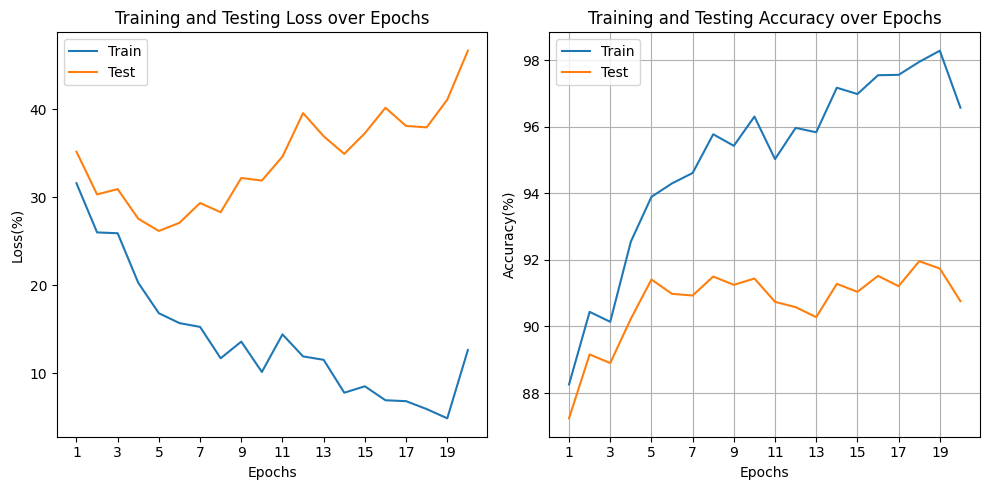

In [ ]:
# plotting test and train loss and accuracy
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

# Approach 3 : Freeze all but the last fully connected layer

In [ ]:
resnet18_3 = torchvision.models.resnet18(weights='DEFAULT') # equivalent to weights='IMAGENET1K_V1'
for name, param in resnet18_3.named_parameters():
  if name not in ['fc.weight', 'fc.bias']:
    param.requires_grad = False  # freezing all but the last layer 'fc'
resnet18_3.fc = nn.Linear(resnet18_3.fc.in_features, 10)
model = resnet18_3.to(device)
summary(model, (3,7,7))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           9,408
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

In [ ]:
train_loss, train_accuracy, test_loss, test_accuracy = Train_model(train_dataloader, test_dataloader, model)

Epoch 1:

loss: 2.877582  [   64/60000]
loss: 1.188221  [ 6464/60000]
loss: 0.864376  [12864/60000]
loss: 0.987467  [19264/60000]
loss: 1.006953  [25664/60000]
loss: 0.981570  [32064/60000]
loss: 0.852846  [38464/60000]
loss: 0.827546  [44864/60000]
loss: 1.107228  [51264/60000]
loss: 0.929288  [57664/60000]
Train Error: 
 Accuracy: 71.9%, Avg loss: 0.831429 

Test Error: 
 Accuracy: 70.6%, Avg loss: 0.861374 

Epoch 2:

loss: 0.864762  [   64/60000]
loss: 0.844972  [ 6464/60000]
loss: 0.773689  [12864/60000]
loss: 0.809148  [19264/60000]
loss: 0.863156  [25664/60000]
loss: 0.897840  [32064/60000]
loss: 0.790178  [38464/60000]
loss: 0.808006  [44864/60000]
loss: 1.083287  [51264/60000]
loss: 0.876846  [57664/60000]
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.789211 

Test Error: 
 Accuracy: 71.6%, Avg loss: 0.829666 

Epoch 3:

loss: 0.852695  [   64/60000]
loss: 0.791188  [ 6464/60000]
loss: 0.761823  [12864/60000]
loss: 0.782693  [19264/60000]
loss: 0.811527  [25664/60000]
loss: 0.86

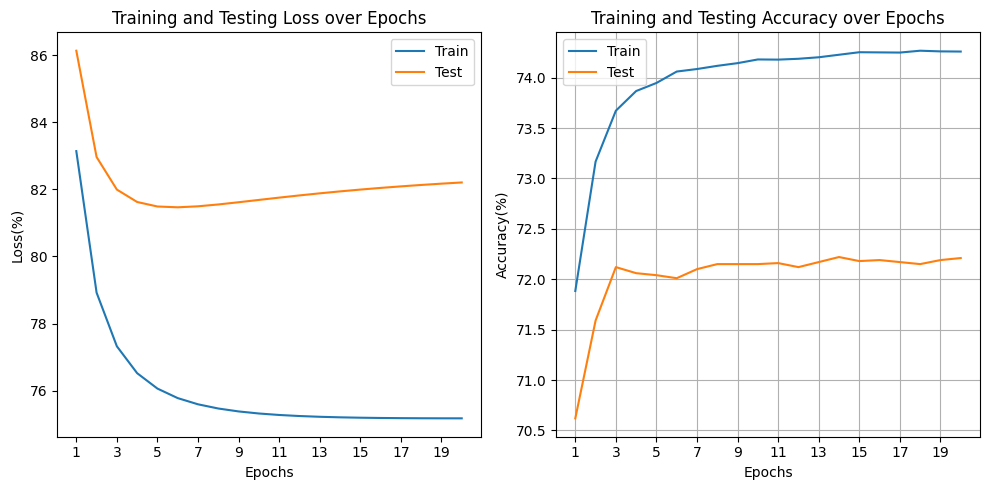

In [ ]:
plot_train_test(train_loss, train_accuracy, test_loss, test_accuracy)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

<span style="color:green"># Approach 1 : Random Weights
The model starts with Random Weights and hence the weights assigned would be what is in the memory and would need to train and update all the weights. This makes it computationally expensive as the model has no prior knowledge about the train data. The only advantage is we are using a tested architecture. Here the best train accuracy is 97% and the test accuracy is 91%. Here we can see considerable overfitting. </span>

<span style="color:green"># Approach 2: Default or IMAGENET1K_V1 weights
Here we load the Resnet18 model with pre-trained weights. This means that the model has knowledge of some features that it has already learned using the IMAGENET1K_V1 weights. Hence it requires less data and consequently less time to converge. Here the best test accuracy is 92% and train accuracy corresponding to it is 97.9%. Here as well we can see considerable overfitting. </span>

<span style="color:green"># Approach 3 : Freeze all but the last layer
Typically used when we have less data to train on. Since we are only working with the last fully connected layer, hence the number of parameters we train would be limited. This is also the reason for the lower accuracy. Here the best training accuracy is 74.2% and test accuracy is 72.2%. Even though the accuracy is not as high as the previous results, we see a lower rate of overfitting with this model. This could be because of the number of parameters we use here for training is considerably less(5130).</span>